In [1]:
%matplotlib notebook
%load_ext autoreload
%pwd

'/ocean/projects/asc170022p/mtragoza/lung-project/notebooks'

In [2]:
import sys, os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

import numpy as np
import xarray as xr

sys.path.append('..')
import project

--------------------------------------------------------------------------
but there are no active ports detected (or Open MPI was unable to use
them).  This is most certainly not what you wanted.  Check your
cables, subnet manager configuration, etc.  The openib BTL will be
ignored for this job.

  Local host: dv002
--------------------------------------------------------------------------


In [3]:
%autoreload
emory4dct = project.imaging.Emory4DCT('../data/Emory-4DCT')
emory4dct.load_images()

Loading ../data/Emory-4DCT/Case1Pack/Images/case1_T00_s.img
Loading ../data/Emory-4DCT/Case1Pack/Images/case1_T10_s.img
Loading ../data/Emory-4DCT/Case1Pack/Images/case1_T20_s.img
Loading ../data/Emory-4DCT/Case1Pack/Images/case1_T30_s.img
Loading ../data/Emory-4DCT/Case1Pack/Images/case1_T40_s.img
Loading ../data/Emory-4DCT/Case1Pack/Images/case1_T50_s.img
Loading ../data/Emory-4DCT/Case1Pack/Images/case1_T60_s.img
Loading ../data/Emory-4DCT/Case1Pack/Images/case1_T70_s.img
Loading ../data/Emory-4DCT/Case1Pack/Images/case1_T80_s.img
Loading ../data/Emory-4DCT/Case1Pack/Images/case1_T90_s.img
Loading ../data/Emory-4DCT/Case2Pack/Images/case2_T00-ssm.img
Loading ../data/Emory-4DCT/Case2Pack/Images/case2_T10-ssm.img
Loading ../data/Emory-4DCT/Case2Pack/Images/case2_T20-ssm.img
Loading ../data/Emory-4DCT/Case2Pack/Images/case2_T30-ssm.img
Loading ../data/Emory-4DCT/Case2Pack/Images/case2_T40-ssm.img
Loading ../data/Emory-4DCT/Case2Pack/Images/case2_T50-ssm.img
Loading ../data/Emory-4DCT/C

<IPython.core.display.Javascript object>


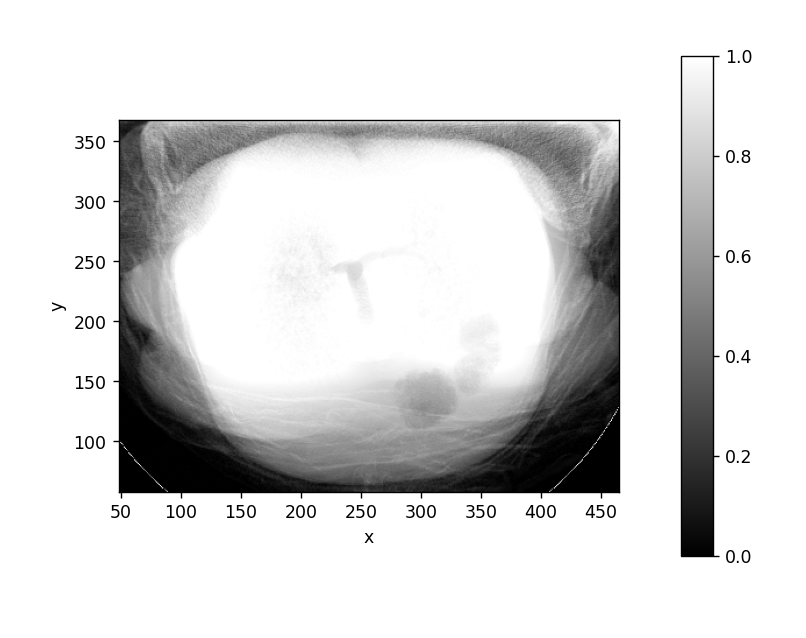

interactive(children=(Output(),), _dom_classes=('widget-interact',))

<IPython.core.display.Javascript object>


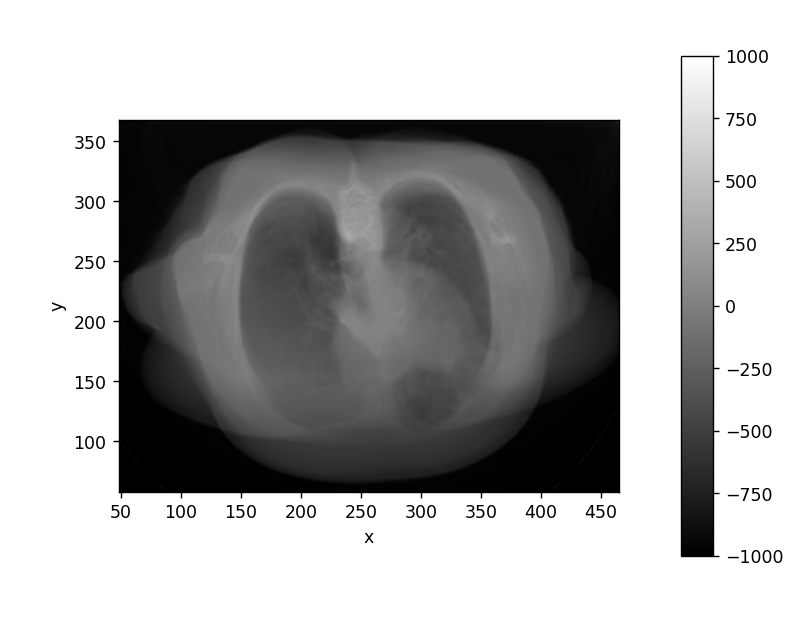

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [25]:
# manually annotate xy crops for each case
crops = [
    {'y': slice(20, 230)},
    {'y': slice( 0, 240)},
    {'y': slice(15, 245)},
    {'y': slice( 0, 255)},
    {'y': slice(10, 270)},
    
    {'x': slice(50, 500), 'y': slice(50, 380)},
    {'x': slice(50, 480), 'y': slice(80, 390)},
    {'x': slice(40, 450), 'y': slice(40, 350)},
    {'x': slice(50, 470), 'y': slice(90, 380)},
    {'x': slice(50, 480), 'y': slice(60, 380)},
]

i = 9
case = emory4dct[i]
anat = case.anat.sel(phase=0).mean('z')
mask = (case.anat.sel(phase=0) > -950).mean('z')

project.visual.view(mask[crops[i]], x='x', y='y', vmin=0, vmax=1)
project.visual.view(anat[crops[i]], x='x', y='y')

1.2795698924731183


<IPython.core.display.Javascript object>


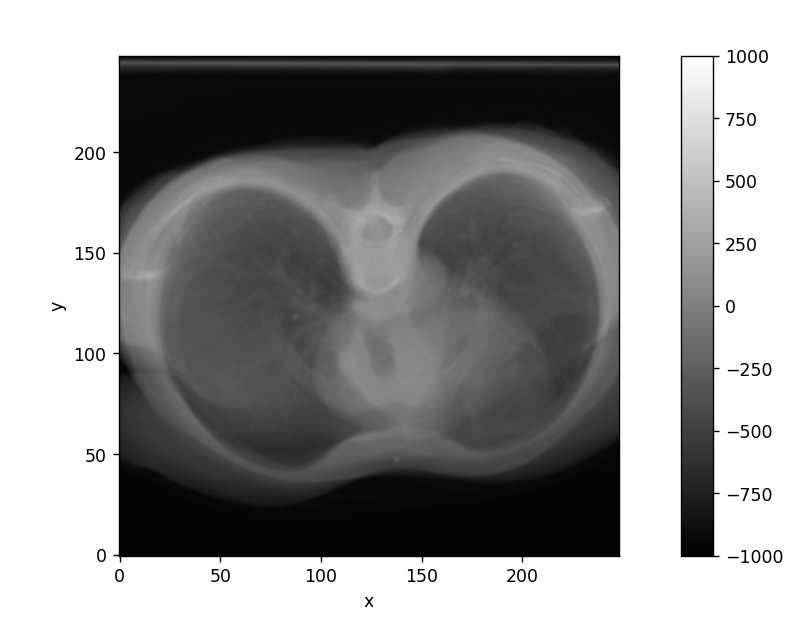

interactive(children=(Output(),), _dom_classes=('widget-interact',))

<IPython.core.display.Javascript object>


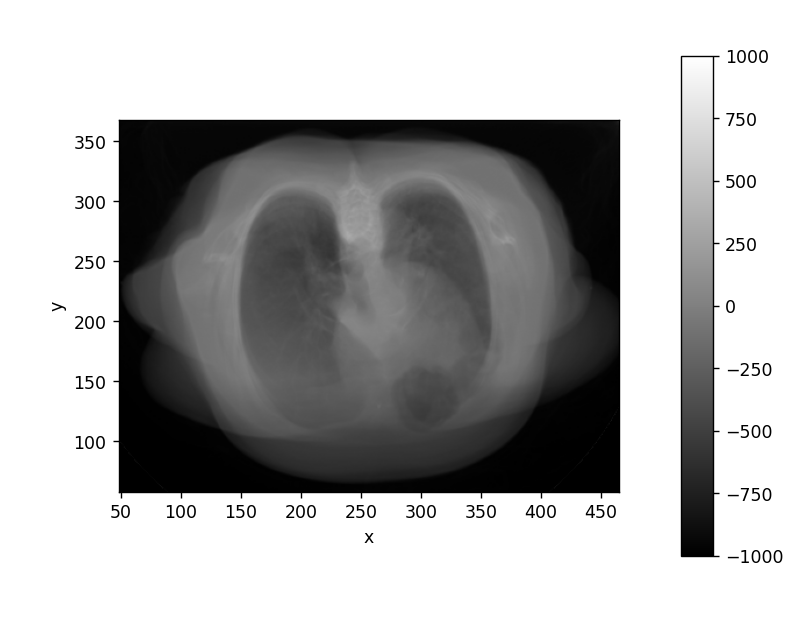

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [79]:
# register a single image pair

i = 9
case_fix = emory4dct[0]
case_mov = emory4dct[i]

anat_fix = case_fix.anat.sel(phase=0)
anat_mov = case_mov.anat.sel(phase=0)[crops[i]]

z_extent_fix = (anat_fix.z[-1] - anat_fix.z[0]).values
z_extent_mov = (anat_mov.z[-1] - anat_mov.z[0]).values
scale_init = z_extent_mov / z_extent_fix
print(scale_init)

project.visual.view(anat_fix.mean('z'), x='x', y='y')
project.visual.view(anat_mov.mean('z'), x='x', y='y')

In [80]:
%autoreload

transform = project.register.register_array(
    anat_mov,
    anat_fix,
    transform='similarity',
    center='geometry',
    metric='MI',
    scale_init=scale_init,
    num_scale_steps=0,
    learning_rate=1.0,
    num_iterations=0,
    print_every=1
)
scale_pred = transform.GetScale()
#scale_final = (scale_init + scale_pred) / 2
#transform.SetScale(scale_final)

warped = project.register.transform_array(
    anat_mov, anat_fix, transform, default=-1000
)

Start exhaustive search...
(0.0, 0.0, 0.0, 132.88999999999976, 89.24000000000093, 32.5, 1.2795698924731183) metric = -0.1621
Start iterative refinement...


<IPython.core.display.Javascript object>


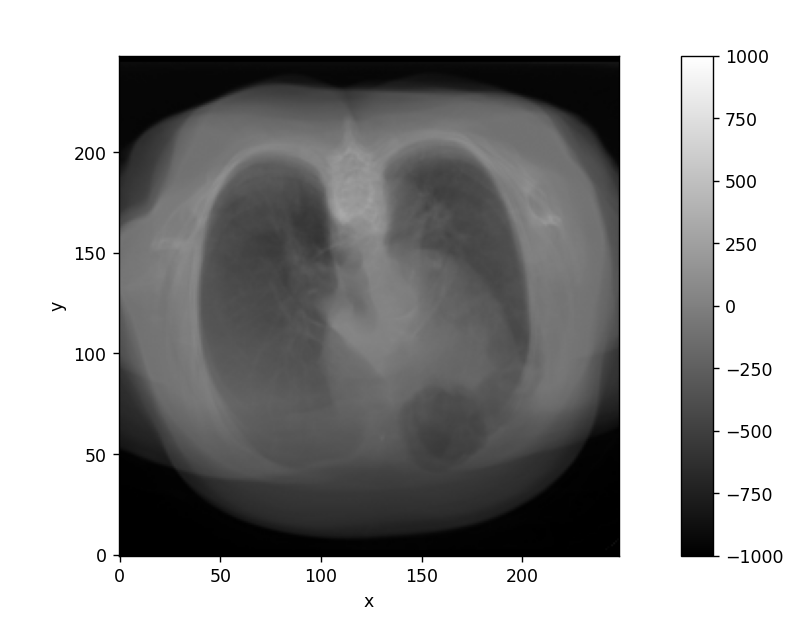

interactive(children=(Output(),), _dom_classes=('widget-interact',))

<IPython.core.display.Javascript object>


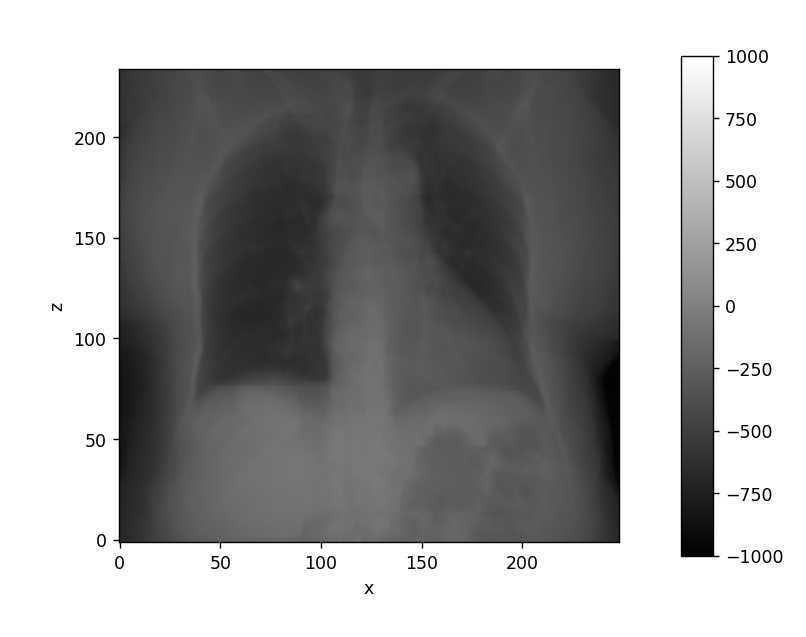

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [81]:
project.visual.view(warped.mean('z'), x='x', y='y')
project.visual.view(warped.mean('y'), x='x', y='z')

In [83]:
%%time

# register all cases to case 1 at EI phase

transforms = []
for i in range(len(emory4dct)):

    case_fix = emory4dct[0]
    case_mov = emory4dct[i]

    print(f'Registering {case_mov.case_name} to {case_fix.case_name}')

    # get transformation by registering at EI phase
    anat_fix = case_fix.anat.sel(phase=0)
    anat_mov = case_mov.anat.sel(phase=0)[crops[i]]
    
    z_extent_fix = (anat_fix.z[-1] - anat_fix.z[0]).values
    z_extent_mov = (anat_mov.z[-1] - anat_mov.z[0]).values
    scale_init = z_extent_mov / z_extent_fix
    
    transform = project.register.register_array(
        anat_mov,
        anat_fix,
        transform='similarity',
        center='geometry',
        metric='MI',
        scale_init=scale_init,
        num_scale_steps=0,
        num_iterations=0,
    )
    transforms.append(transform)

    # apply same transformation to all phases
    all_warped = []
    for phase in emory4dct.phases:
        print(f'Transforming {case_mov.case_name} phase {phase}')
        
        anat_fix = case_fix.anat.sel(phase=phase)
        anat_mov = case_mov.anat.sel(phase=phase)
        anat_warp = project.register.transform_array(anat_mov, anat_fix, transform, default=-1000)
        all_warped.append(anat_warp)
    
    # REPLACE existing image with warped image
    case_mov.anat = xr.concat(all_warped, dim=case_mov.anat.phase)
    case_mov.anat.name = 'CT'

    scale = transform.GetScale()
    case_mov.shape = case_fix.shape
    case_mov.resolution = [r * scale for r in case_fix.resolution]

Registering Case1Pack to Case1Pack
Start exhaustive search...
(0.0, 0.0, 0.0, 0.0, -2.909999999999755, 0.0, 1.0) metric = -0.5089
Start iterative refinement...
Transforming Case1Pack phase 0
Transforming Case1Pack phase 10
Transforming Case1Pack phase 20
Transforming Case1Pack phase 30
Transforming Case1Pack phase 40
Transforming Case1Pack phase 50
Transforming Case1Pack phase 60
Transforming Case1Pack phase 70
Transforming Case1Pack phase 80
Transforming Case1Pack phase 90
Registering Case2Pack to Case1Pack
Start exhaustive search...
(0.0, 0.0, 0.0, 24.22499999999998, 14.945000000000007, 22.5, 1.1935483870967742) metric = -0.2103
Start iterative refinement...
Transforming Case2Pack phase 0
Transforming Case2Pack phase 10
Transforming Case2Pack phase 20
Transforming Case2Pack phase 30
Transforming Case2Pack phase 40
Transforming Case2Pack phase 50
Transforming Case2Pack phase 60
Transforming Case2Pack phase 70
Transforming Case2Pack phase 80
Transforming Case2Pack phase 90
Registering 

In [84]:
all_anat = xr.DataArray(
    np.stack([case.anat.values for case in emory4dct.cases], axis=0),
    dims=['case', 'phase', 'x', 'y', 'z'],
    coords={
        'case': emory4dct.case_names,
        'phase': emory4dct.phases,
        'x': emory4dct[0].anat.x.values,
        'y': emory4dct[0].anat.y.values,
        'z': emory4dct[0].anat.z.values,
    }
)
all_anat

<xarray.DataArray (case: 10, phase: 10, x: 256, y: 256, z: 94)> Size: 1GB
array([[[[[-1000, -1000, -1000, ..., -1000, -1000, -1000],
          [-1000, -1000, -1000, ..., -1000, -1000, -1000],
          [-1000, -1000, -1000, ..., -1000, -1000, -1000],
          ...,
          [ -626,  -632,  -680, ...,  -716,  -664,  -796],
          [ -545,  -551,  -562, ...,  -388,  -458,  -494],
          [ -399,  -405,  -384, ...,  -381,  -347,  -422]],

         [[-1000, -1000, -1000, ..., -1000, -1000, -1000],
          [-1000, -1000, -1000, ..., -1000, -1000, -1000],
          [-1000, -1000, -1000, ..., -1000, -1000, -1000],
          ...,
          [ -616,  -624,  -670, ...,  -724,  -672,  -809],
          [ -548,  -533,  -547, ...,  -380,  -452,  -499],
          [ -402,  -398,  -367, ...,  -375,  -353,  -414]],

         [[-1000, -1000, -1000, ..., -1000, -1000, -1000],
          [-1000, -1000, -1000, ..., -1000, -1000, -1000],
          [-1000, -1000, -1000, ..., -1000, -1000, -1000],
          ...,
...
          ...,
          [ -843,  -834,  -797, ...,  -668,  -490,  -213],
          [ -693,  -686,  -687, ...,  -491,  -390,  -477],
          [ -436,  -455,  -416, ...,  -724,  -725,  -701]],

         [[ -999,  -999,  -999, ...,  -999,  -999,  -999],
          [-1000, -1000, -1000, ..., -1000, -1000, -1000],
          [ -999,  -999,  -999, ...,  -999,  -999,  -999],
          ...,
          [ -831,  -818,  -856, ...,  -663,  -521,  -192],
          [ -707,  -707,  -655, ...,  -509,  -420,  -490],
          [ -499,  -428,  -448, ...,  -723,  -749,  -682]],

         [[-1000, -1000, -1000, ..., -1000, -1000, -1000],
          [ -999,  -999,  -999, ...,  -999,  -999,  -999],
          [-1000, -1000, -1000, ..., -1000, -1000, -1000],
          ...,
          [ -864,  -857,  -868, ...,  -657,  -516,  -186],
          [ -640,  -661,  -667, ...,  -532,  -432,  -500],
          [ -462,  -492,  -433, ...,  -729,  -756,  -695]]]]], dtype=int16)
Coordinates:
  * case     (case) <U11 440B 'Case1Pack' 'Case2Pack' ... 'Case10Pack'
  * phase    (phase) int64 80B 0 10 20 30 40 50 60 70 80 90
  * x        (x) float64 2kB 0.0 0.97 1.94 2.91 3.88 ... 244.4 245.4 246.4 247.3
  * y        (y) float64 2kB 0.0 0.97 1.94 2.91 3.88 ... 244.4 245.4 246.4 247.3
  * z        (z) float64 752B 0.0 2.5 5.0 7.5 10.0 ... 225.0 227.5 230.0 232.5

<IPython.core.display.Javascript object>


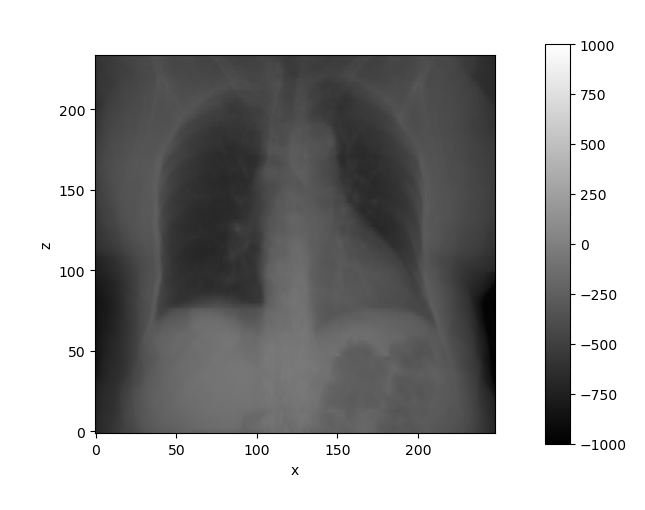

interactive(children=(SelectionSlider(description='case', options=(('Case1Pack', 0), ('Case2Pack', 1), ('Case3…

In [88]:
all_anat.name = 'CT'
project.visual.view(all_anat.mean('y'), x='x', y='z')

In [87]:
# save warped images as NIFTI files
emory4dct.save_niftis()

Saving ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T00.nii.gz
Saving ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T10.nii.gz
Saving ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T20.nii.gz
Saving ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T30.nii.gz
Saving ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T40.nii.gz
Saving ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T50.nii.gz
Saving ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T60.nii.gz
Saving ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T70.nii.gz
Saving ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T80.nii.gz
Saving ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T90.nii.gz
Saving ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T00.nii.gz
Saving ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T10.nii.gz
Saving ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T20.nii.gz
Saving ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T30.nii.gz
Saving ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T40.nii.gz
Saving ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T50.nii.gz
Saving ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T60.nii.